## Chapter 3. Creating Representations with DeepWalk

DeepWalk는 graph data를 다루는 ML 분야에서 성공적인 적용 사례 중 하나이다. GNN의 핵심 concept인 embedding 과정에서 핵심 역할을 한다. 전통적인 Neural Network와 달리 DeepWalk의 목표는 representation을 통해 Node Classification 작업에 활용될 수 있는 전처리 과정에 포함된다.

DeepWalk를 이행하기 위해서는 NLP에서 주로 활용되는 Word2Vec(2013, Mikolov et al.)에 대한 이해가 필요하다. 이 기법은 대규모 텍스트 데이터셋을 활용하여 단어를 벡터(또는 embedding)로 변환하는 것이다.

Word2Vec: 분산 표현(Distributed Representation) 방식으로 단어를 벡터화하여, 의미가 비슷한 단어들이 벡터 공간에서 가깝도록 배치하는 것이다. 즉, 단어의 의미적 관계를 학습하는 것이 핵심.

Word2Vec의 핵심:
1. 분산 표현
+ 단어를 고정된 차원의 벡터로 변환
+ 단어의 의미를 벡터 공간에서 표현하여 유사한 단어가 가까이 위치함

2. 학습 방식
- CBOW(Continuous Bag of words): 주변 단어(Context)들을 보고 중심 단어를 예측, 문맥 기반으로 학습하기 때문에 작은 데이터셋에서 효과적이다.
- Skip-gram: 중심 단어를 보고 주변 단어들을 예측, 희소한 데이터에서도 강력한 성능을 보이고 단어 의미를 더 정밀하게 반영 가능하지만 연산량이 많아 학습 속도가 느리다는 단점이 있다.

🚀 DeepWalk에서는 그래프를 단어 시퀀스처럼 취급하여 적용하는 아키텍처는 Skip-gram모델이다.

## Skip-gram 실습

In [1]:
import numpy as np
import warnings

warnings.filterwarnings('ignore')

In [2]:
context_size = 2

text = """Lorem ipsum dolor sit amet, consectetur
adipiscing elit. Nunc eu sem scelerisque, dictum eros
aliquam, accumsan quam. Pellentesque tempus, lorem ut
semper fermentum, ante turpis accumsan ex, sit amet
ultricies tortor erat quis nulla. Nunc consectetur ligula
sit amet purus porttitor, vel tempus tortor scelerisque.
Vestibulum ante ipsum primis in faucibus orci luctus
et ultrices posuere cubilia curae; Quisque suscipit
ligula nec faucibus accumsan. Duis vulputate massa sit
amet viverra hendrerit. Integer maximus quis sapien id
convallis. Donec elementum placerat ex laoreet gravida.
Praesent quis enim facilisis, bibendum est nec, pharetra
ex. Etiam pharetra congue justo, eget imperdiet diam
varius non. Mauris dolor lectus, interdum in laoreet
quis, faucibus vitae velit. Donec lacinia dui eget
maximus cursus. Class aptent taciti sociosqu ad litora
torquent per conubia nostra, per inceptos himenaeos.
Vivamus tincidunt velit eget nisi ornare convallis.
Pellentesque habitant morbi tristique senectus et netus
et malesuada fames ac turpis egestas. Donec tristique
ultrices tortor at accumsan.
""".split()

skip_gram = []

for i in range(context_size, len(text) - context_size):
    array = [text[j] for j in np.arange(i - context_size, i + context_size + 1) if j != i]
    skip_gram.append((text[i], array))

# 두개의 target word에 대한 양 옆의 2개(context_size) 에 따른 Word2Vec 입력 확인
print(skip_gram[0:2])

[('dolor', ['Lorem', 'ipsum', 'sit', 'amet,']), ('sit', ['ipsum', 'dolor', 'amet,', 'consectetur'])]


Word2Vec의 목표는 양질의 단어 임베딩을 생성하는 것이다. 이러한 임베딩을 학습하기 위해 skip-gram 모델의 학습 과제는 주어진 목표 단어에 맞는 올바른 컨텍스트 단어를 예측하는 것임.

$w_1$, $w_2$, $w_3$, ..., $w_n$ 이라는 단어 시퀀스가 존재할 때, $w_2$가 등장할 확률을 $P(w_2|w_1)$라고 한다면 목표는 전체 텍스트에서 주어진 target 단어를 볼 수 있는 모든 확률의 합을 최대화하는 것이다.

$$
\frac{1}{N} \sum_{n=1}^{N} \sum_{\substack{-c \leq j \leq c ,\\ j \neq 0}} \log p(w_{n+j} | w_n)
$$

🙋로그 확률을 사용하는 이유:
1. 로그는 곱셈이 덧셈이 되고, 나눗셈은 뺄셈이 되기 때문이다. 따라서 곱셈은 덧셈보다 계산 비용이 더 많이 요구되어 로그 확률을 계산하는 것이 빠르다.
2. 컴퓨터가 매우 작은 숫자를 저장하는 방식은 동일한 숫자의 로그와 달리 완벽하게 정확하지 않다. 이는 작은 오류를 발새시켜 최종 결과에 변화를 초래할 수 있다.

따라서, Skip-gram 모델은 Softmax 함수를 활용하여 target 단어 입베딩 $h_t$가 주어졌을 때, 문맥 단어 임베딩 $h_c$의 확률을 계산하는 것이다.

$$
p(w_c | w_t) = \frac{\exp \left( h_c h_t^T \right)}{\sum_{i=1}^{|V|} \exp \left( h_i h_t^T \right)}
$$

In [3]:
vocab = set(text)
vocab_size = len(vocab)
print(f"단어의 갯수: {vocab_size}")

단어의 갯수: 121


단어의 갯수가 정해지면, word vector의 크기를 정해주면 된다. 일반적으로 100에서 1000 사이의 값으로 지정해주면 되지만, 본 실습에서는 데이터 셋의 크기가 제한되어 있기 때문에 10으로 설정한다. 

skip-gram 모델은 두 개의 레이어로만 구성된다.
- 가중치 행렬이 있는 Projection layer: one-hot 인코딩된 word vector를 입력으로 받아 $N$ 차원의 word 임베딩을 수행
- $|V|$ 차원의 logit을 출력하는 Fully connected layer: 이 과정에서 softmax 함수가 적용되어 logit을 확률로 변환해준다.

※ Word2Vec에서는 단어들 간의 선형 관계만을 보기 때문에 활성화 함수는 사용되지 않는다.

위와 같이 작은 단어 데이터셋에는 일반적인 Softmax 함수가 활용 가능하지만, 수백만 개의 단어에 대해서는 계산 비용이 크다. 따라서 Word2Vec에서는 H-softmax 함수를 통해 모든 단어의 확률을 직접 계산하는 것이 아닌 이진 트리 구조 기반의 연산을 수행하여 단어 예측 속도가 50배이상 빨라질 수 있다.

In [4]:
from gensim.models.word2vec import Word2Vec

model = Word2Vec([text],
                 sg=1, #skip-gram
                 vector_size=10,
                 min_count=0,
                 window=2,
                 seed=0,
                 hs = 1 # hierarchical softmax
                 )

print(f"임베딩 된 단어의 차원: {model.wv.vectors.shape}") # 임베딩된 첫번째 가중치 행렬의 차원을 확인

임베딩 된 단어의 차원: (121, 10)


In [5]:
model.train([text], total_examples=model.corpus_count, epochs=10) # epoch 는 10

print(f'Word embedding = {model.wv[0]}') # training된 단어 임베딩 결과 출력

Word embedding = [ 0.07355797  0.0365127   0.00413889 -0.04254594 -0.0358349  -0.08933334
 -0.09325401 -0.09581503 -0.06472032  0.06599101]


## 📖 DeepWalk

DeepWalk의 목표는 비지도 방식으로 노드의 feature representations을 수행하는 것이다. NLP의 Word2Vec에서 영감을 받아 개발되었고, 단어 대신 노드로 구성되어 있는 그래프 데이터셋을 활용하기 때문에 RandomWalk를 사용하여 문장처럼 작동하는 의미 있는 노드 시퀀스를 생성한다.

RandomWalk는 인접 노드를 무작위로 선택하여 생성된 노드의 시퀀스를 의미한다. 따라서 노드는 동일한 시퀀스로 여러 번 나타날 수 있으며, 네트워크 동질성 가설에 의해서 노드를 무작위로 선택하더라도 종종 시퀀스로 함께 나타난다는 것은 노드가 서로 가깝가는 것을 의미하는 것이다.

In [6]:
## Random Walk 실습

import networkx as nx
import matplotlib.pyplot as plt
import random
random.seed(0)

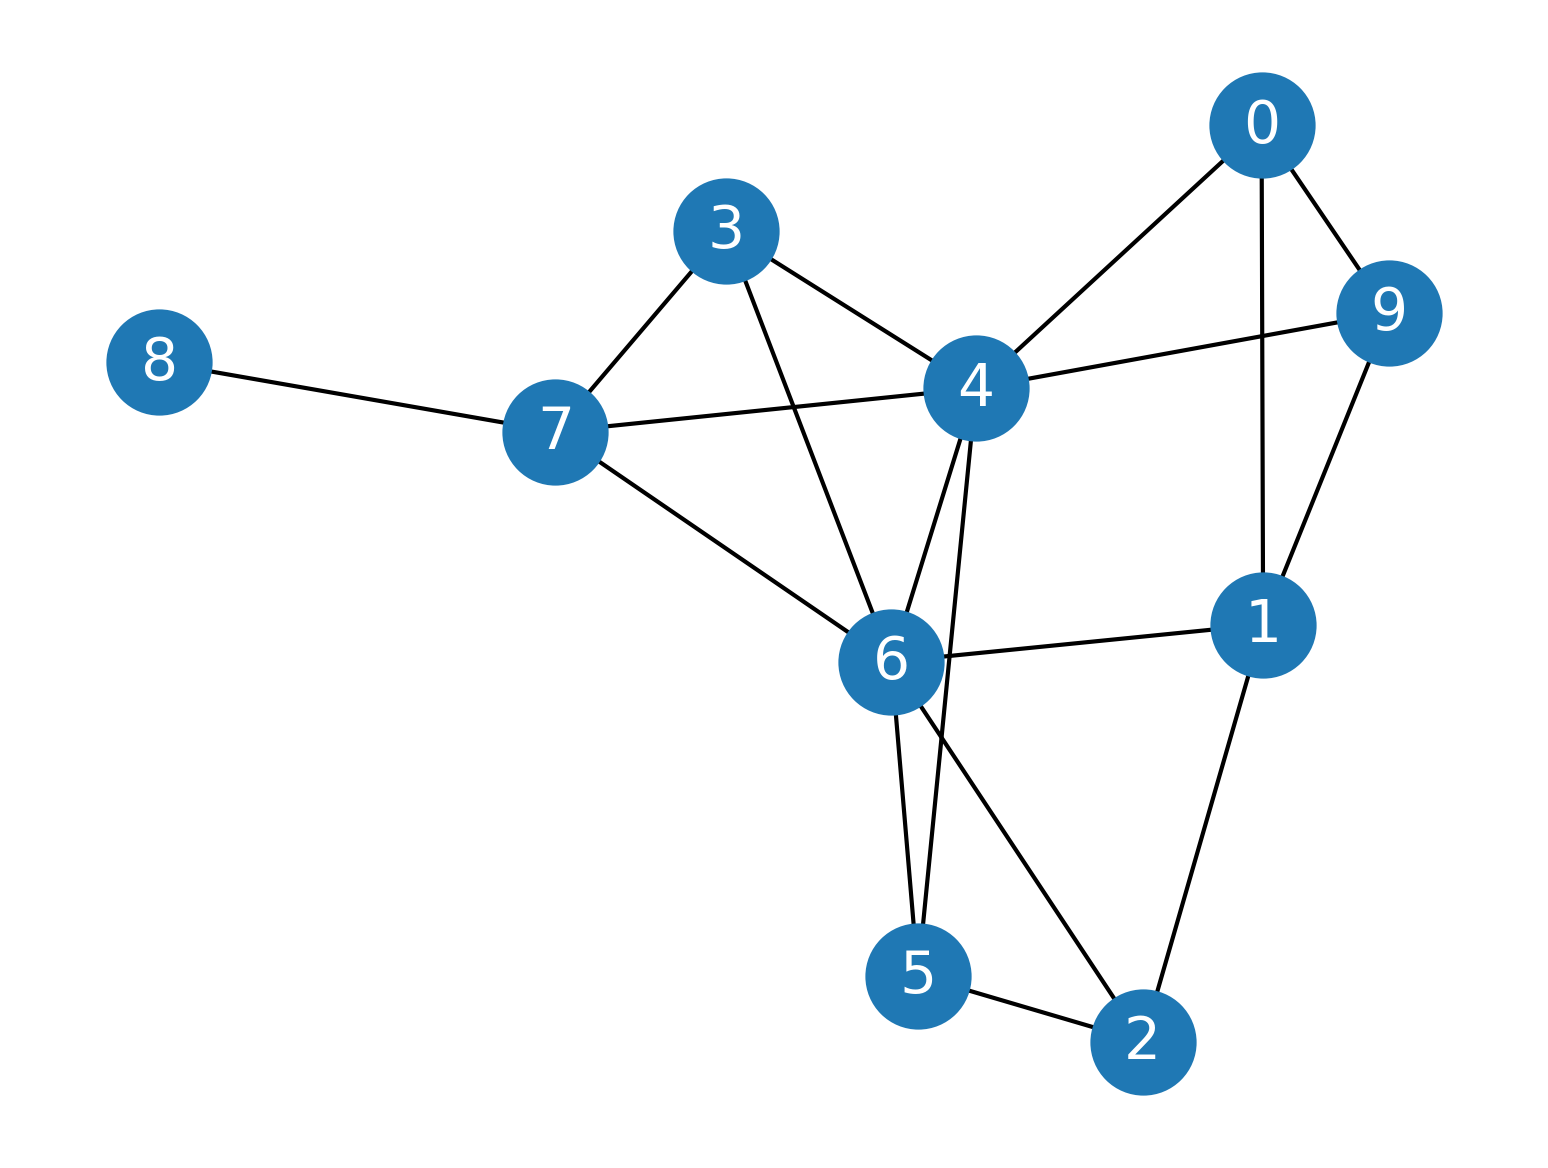

In [7]:
G = nx.erdos_renyi_graph(10, 0.3, seed=1, directed=False)

plt.figure(dpi=300)
plt.axis('off')
nx.draw_networkx(G,
                 pos=nx.spring_layout(G,seed=0),
                 node_size=600,
                 cmap='coolwarm',
                 font_size=14,
                 font_color='white')

In [8]:
## 0, 4와 같은 특정 노드가 함께 나타나는 것은 동질성 그래프라는 점을 고려했을 때 유사하다는 것을 의미한다.

def random_walk(start, length):
    walk = [str(start)] # 시작 노드

    for i in range(length):
        neighbors = [node for node in G.neighbors(start)]
        next_node = np.random.choice(neighbors,1)[0]
        walk.append(str(next_node))
        start = next_node

    return walk

print(random_walk(0, 10))

['0', '9', '4', '3', '6', '1', '9', '1', '2', '5', '2']


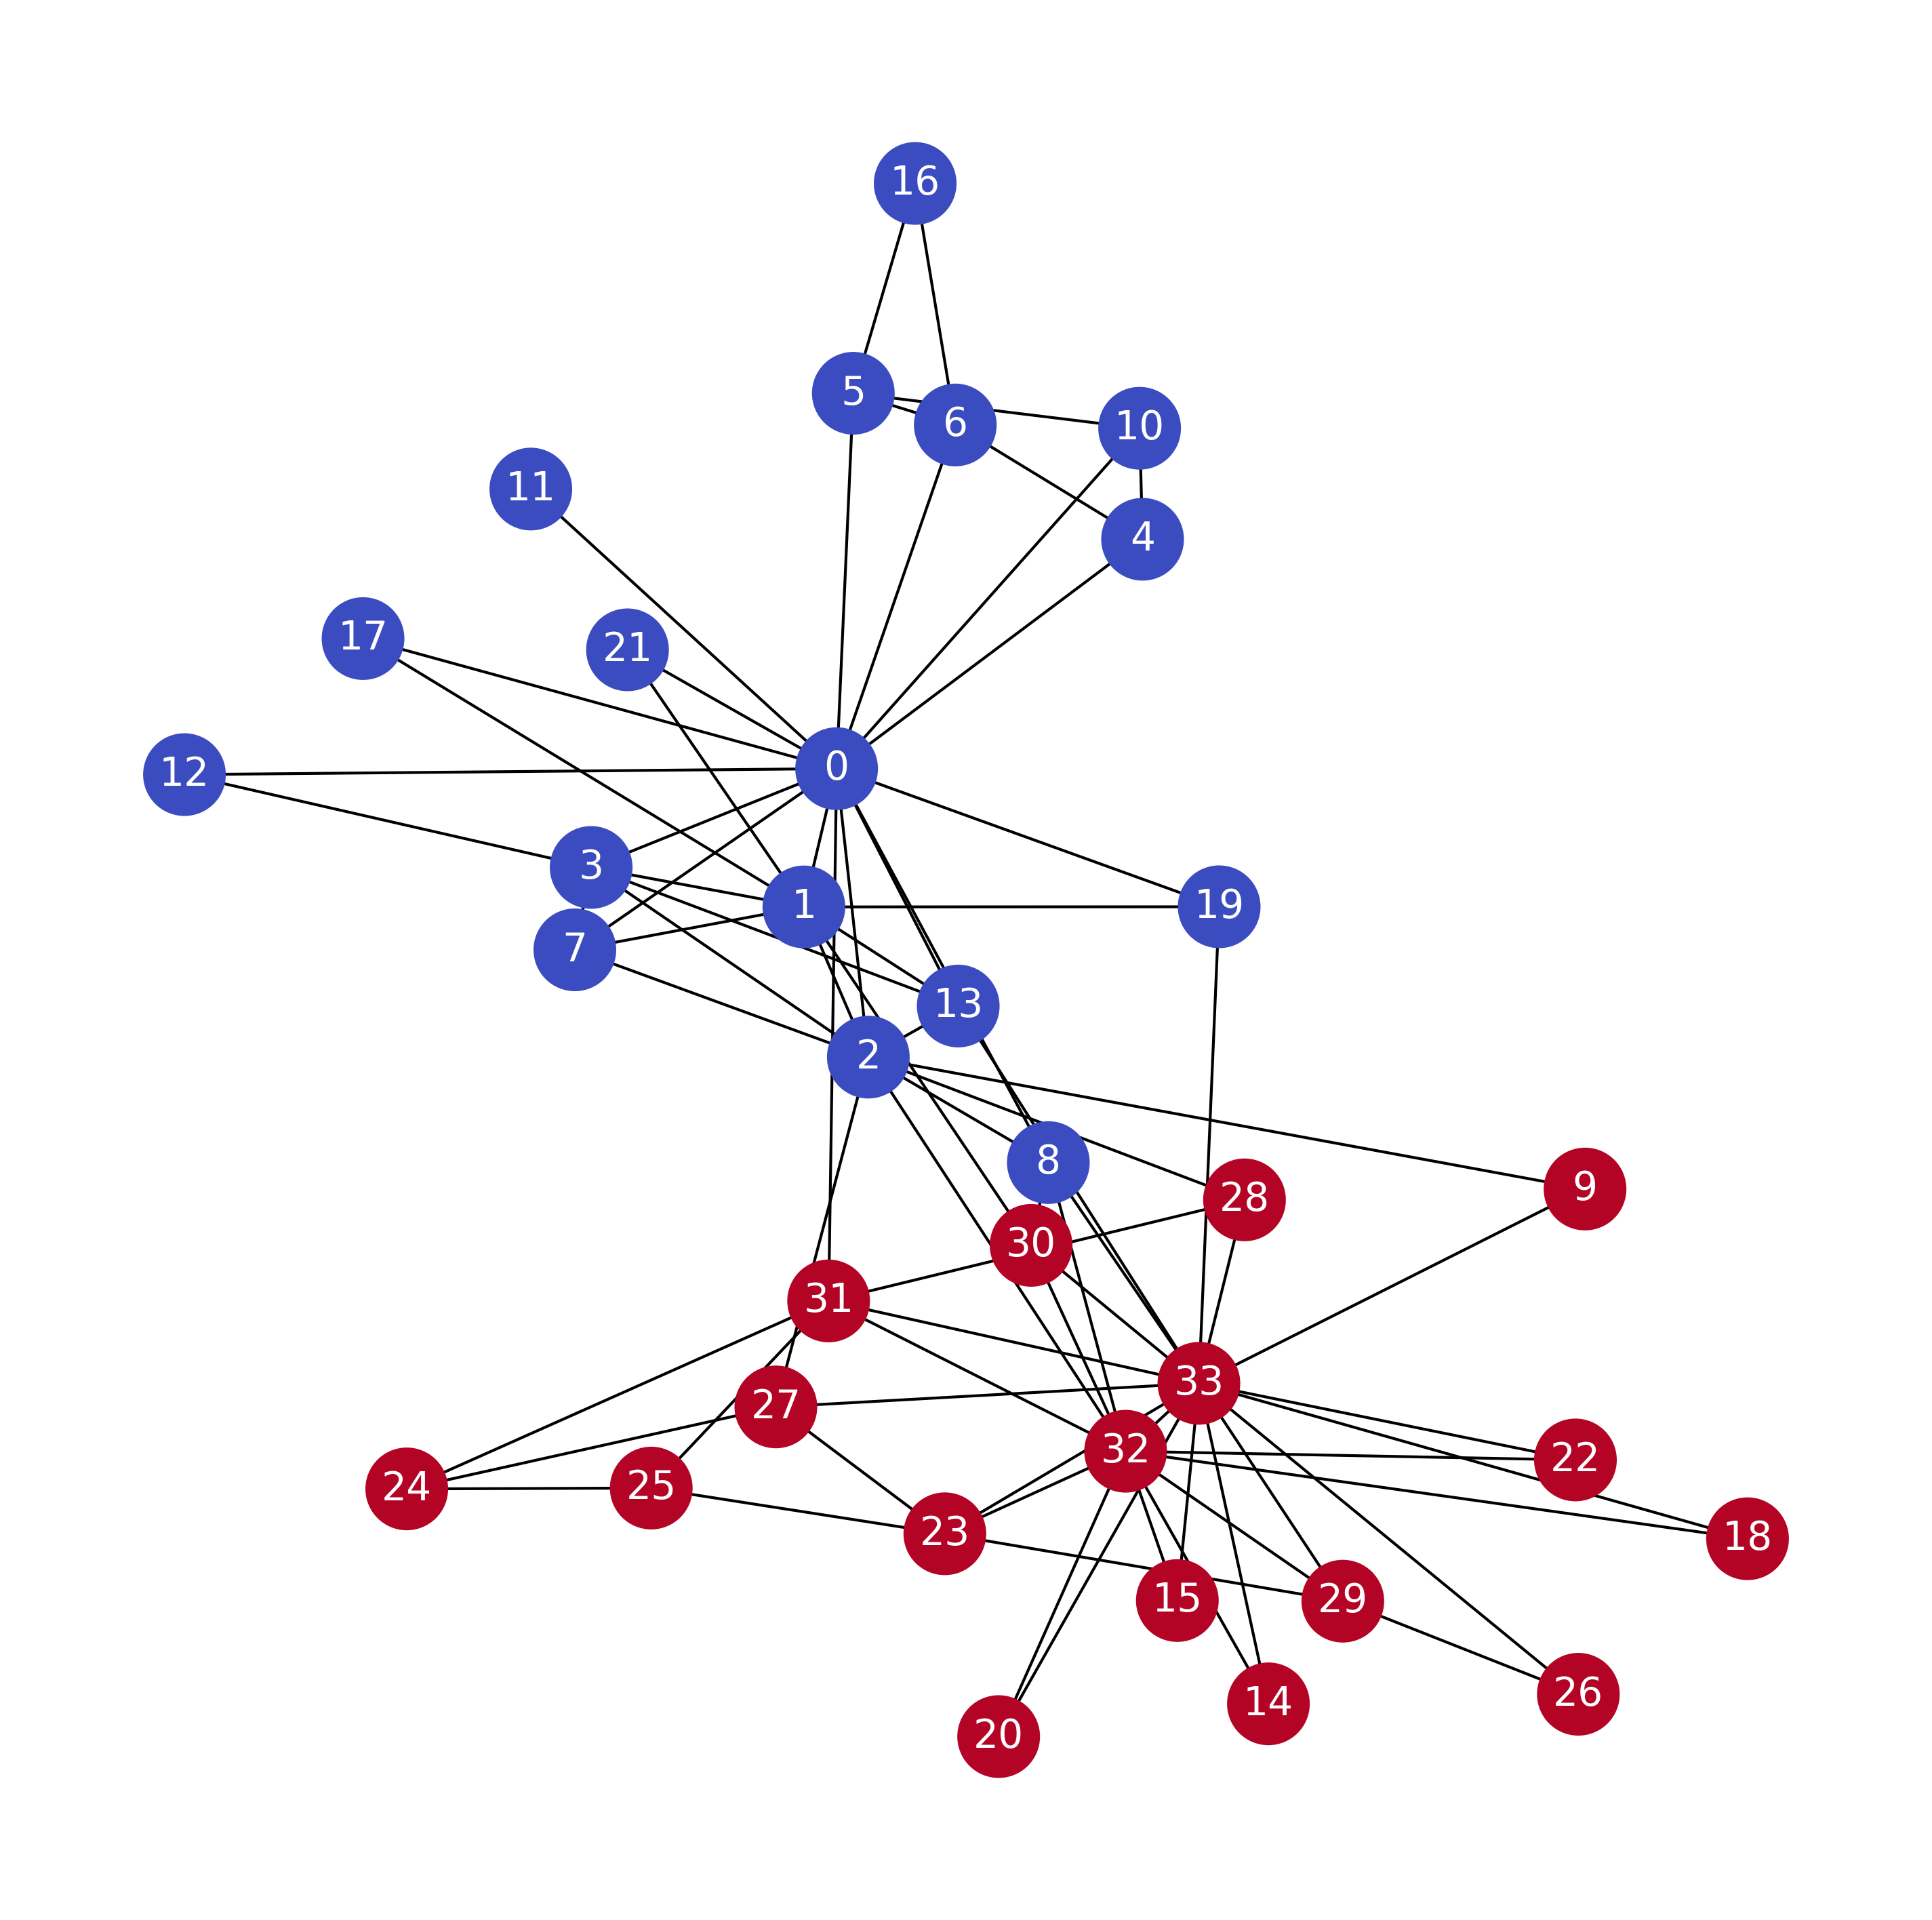

In [9]:
G = nx.karate_club_graph() # 재커리의 가라테 클럽 회원 데이터

labels = []

for node in G.nodes:
    label = G.nodes[node]['club']
    labels.append(1 if label == 'Officer' else 0)

plt.figure(figsize = (12,12), dpi = 300)
plt.axis('off')
nx.draw_networkx(G,
                 pos = nx.spring_layout(G, seed=0),
                 node_color = labels,
                 node_size = 800,
                 cmap = 'coolwarm',
                 font_size = 14,
                 font_color = 'white')

In [10]:
G.nodes[0]

{'club': 'Mr. Hi'}

In [11]:
# Random walk

walks = []

for node in G.nodes:
    for _ in range(80):
        walks.append(random_walk(node, 10))

print(walks[0])

['0', '12', '0', '6', '4', '10', '4', '6', '4', '6', '16']


In [12]:
# Word2Vec을 활용한 임베딩 수행

model = Word2Vec(walks,
 hs=1, # Hierarchical softmax
 sg=1, # Skip-gram
 vector_size=100,
 window=10,
 workers=2,
 seed=0)

model.train(walks, total_examples=model.corpus_count, epochs=30, report_delay=1)

print('노드 0과 가장 유사한 노드:')
for similarity in model.wv.most_similar(positive=['0']):
 print(f' {similarity}')

노드 0과 가장 유사한 노드:
 ('17', 0.6628468036651611)
 ('10', 0.6517664194107056)
 ('11', 0.6510785222053528)
 ('4', 0.6482458114624023)
 ('6', 0.6106897592544556)
 ('21', 0.6022550463676453)
 ('12', 0.5888445377349854)
 ('5', 0.5695135593414307)
 ('1', 0.5653225183486938)
 ('3', 0.5480197072029114)


In [13]:
# 두개 노드 간의 유사도

print(f" 노드 0 과 노드 4의 유사도: {model.wv.similarity('0', '4')}")

 노드 0 과 노드 4의 유사도: 0.6482457518577576


Exception in thread Thread-171:
Traceback (most recent call last):
  File "c:\Users\mmm06\anaconda3\envs\Deep_laerning\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "c:\Users\mmm06\anaconda3\envs\Deep_laerning\lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\mmm06\anaconda3\envs\Deep_laerning\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\mmm06\anaconda3\envs\Deep_laerning\lib\subprocess.py", line 1386, in _readerthread
    buffer.append(fh.read())
  File "c:\Users\mmm06\anaconda3\envs\Deep_laerning\lib\codecs.py", line 322, in decode
    (result, consumed) = self._buffer_decode(data, self.errors, final)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb9 in position 29: invalid start byte
  File "c:\Users\mmm06\anaconda3\envs\Deep_laerning\lib\site-packages\joblib\externals\loky\backend\context.py", line 262, in _count_physical_cores
    

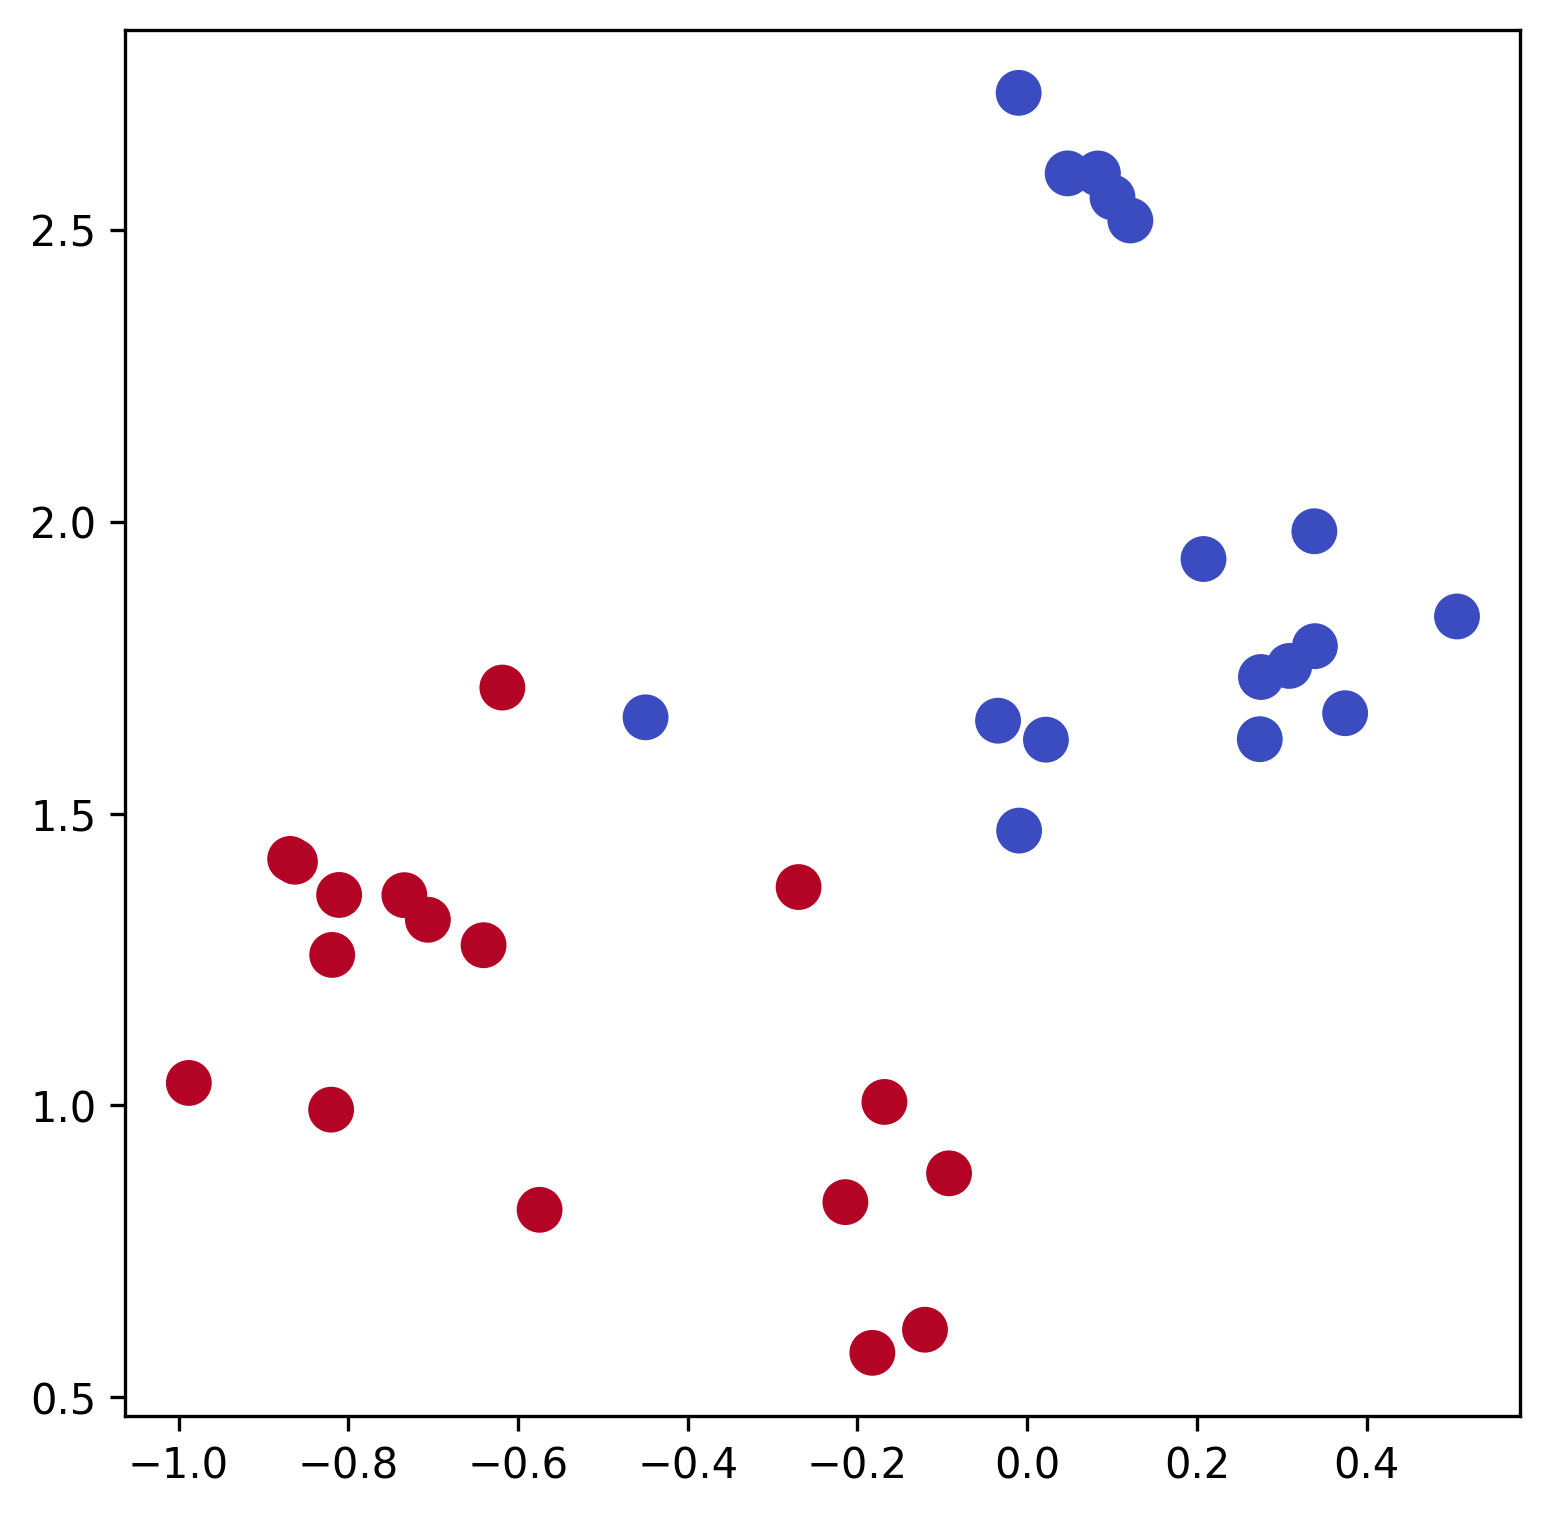

In [14]:
from sklearn.manifold import TSNE # 34개의 노드 별로 보유한 벡터를 차원 축소를 통해 시각화를 진행행

nodes_wv = np.array([model.wv.get_vector(str(i)) for i in range(len(model.wv))])
labels = np.array(labels)

tsne = TSNE(n_components=2,
 learning_rate='auto',
 init='pca',
 random_state=0).fit_transform(nodes_wv)

plt.figure(figsize=(6, 6), dpi=300)
plt.scatter(tsne[:, 0], tsne[:, 1], s=100, c=labels,
cmap="coolwarm")
plt.show()

In [15]:
## 34개의 노드 별로 100개의 임베딩 벡터 -> 2개 차원(TSNE)

print(nodes_wv.shape)

(34, 100)


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

train_mask = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28] # train 노드
test_mask = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 30, 31, 32, 33] # test 노드

clf = RandomForestClassifier(random_state=0)
clf.fit(nodes_wv[train_mask], labels[train_mask])

y_pred = clf.predict(nodes_wv[test_mask])
accuracy_score(y_pred, labels[test_mask])

0.8947368421052632

## Summary

- Random Walk를 통해 그래프 데이터를 시퀀스로 변환 -> Word2Vec 알고리즘을 통해 임베딩 벡터 생성
- 결과적으로 생성된 임베딩 벡터는 노드 간의 유사성을 찾을 수 있었음
- 마지막에 지도 학습 방식의 노드 분류 문제를 통해 DeepWalk 아키텍처의 우수성 확인
- 하지만, Random Walk 방식의 경우 편향된 결과를 보여줄 수 있기 때문에 임베딩 과정에 영향을 미치게 됨